In [44]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

In [45]:
from rxitect.scorers.a2ascore import Predictor
from rdkit.Chem import MolFromSmiles

In [46]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs
import pandas as pd

In [47]:
lows_a2a = []
highs_a2a = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_synth_v2_tb_beta_96_lr_5e-4_nosascore/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_a2a.extend(df[-6250:]["fr_0"])
    cnx.close()
    
lows_a2a_p = []
highs_a2a_p = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_synth_v2_tb_beta_96_lr_5e-4_nosascore/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_a2a_p.extend(df[-6250:]["pref_0"])
    cnx.close()
    
lows_a1 = []
highs_a1 = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_synth_v2_tb_beta_96_lr_5e-4_nosascore/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_a1.extend(df[-6250:]["fr_1"])
    cnx.close()
    
lows_a1_p = []
highs_a1_p = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_synth_v2_tb_beta_96_lr_5e-4_nosascore/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_a1_p.extend(df[-6250:]["pref_1"])
    cnx.close()
    
lows_herg = []
highs_herg = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_synth_v2_tb_beta_96_lr_5e-4_nosascore/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_herg.extend(df[-6250:]["fr_2"])
    cnx.close()
    
lows_herg_p = []
highs_herg_p = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_synth_v2_tb_beta_96_lr_5e-4_nosascore/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_herg_p.extend(df[-6250:]["pref_2"])
    cnx.close()

In [48]:
smis = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_synth_v2_tb_beta_96_lr_5e-4_nosascore/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    smis.extend(df[-6250:]["smi"])
    cnx.close()

In [49]:
mols = [Chem.MolFromSmiles(smi) for smi in smis]

In [50]:
a = pd.DataFrame(pd.Series(lows_a2a), columns=["A2A"])
b = pd.DataFrame(pd.Series(lows_a1), columns=["A1"])
c = pd.DataFrame(pd.Series(lows_herg), columns=["hERG"])
d = pd.concat([a, b, c], axis=1)
e = pd.DataFrame(pd.Series(highs_a2a), columns=["A2A"])
f = pd.DataFrame(pd.Series(highs_a1), columns=["A1"])
g = pd.DataFrame(pd.Series(highs_herg), columns=["hERG"])
h = pd.concat([e, f, g], axis=1)
i = pd.concat([d, h], axis=0)
i.reset_index(inplace=True)
i["index"].iloc[0:80_000] = "First 80K"
i["index"].iloc[-80_000:] = "Last 80K"
i.rename(columns={"index":"samples"}, inplace=True)

/tmp/ipykernel_2579940/1196994486.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  a = pd.DataFrame(pd.Series(lows_a2a), columns=["A2A"])
/tmp/ipykernel_2579940/1196994486.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  b = pd.DataFrame(pd.Series(lows_a1), columns=["A1"])
/tmp/ipykernel_2579940/1196994486.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  c = pd.DataFrame(pd.Series(lows_herg), columns=["hERG"])
/tmp/ipykernel_2579940/1196994486.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [51]:
df = i[i.samples == "Last 80K"]

In [52]:
df["smi"] = smis

In [53]:
from rxitect.scorers.rascore import mol2fcfp, load_rascore_model
fcfps = [mol2fcfp(m) for m in mols]
fcfps = torch.tensor(np.array(fcfps), dtype=torch.float, device="cpu")

In [54]:
ras = load_rascore_model("../models/rascore_26102022.ckpt")
# ras.cpu()
ras_scores = ras(fcfps)

 [*] Loading checkpoint from ../models/rascore_26102022.ckpt succeed!
Checkpoint restored!


In [55]:
from rxitect.scorers.sascore import calculateScore
sas = [calculateScore(m) for m in mols]
sa_scores = (10 - np.array(sas)) / 9  # transform to [0-1]

In [56]:
from rdkit.Chem import QED
from rdkit.Chem.Descriptors import MolWt

In [57]:
qeds = [QED.qed(m) for m in mols]
mws = torch.from_numpy(np.array([MolWt(m) for m in mols]))
sc_mws = (mws / 1000).clip(0, 1)

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    fig = None
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    if fig:
        cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
        cbar.ax.set_ylabel('Density')

    return ax

In [59]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [60]:
dfx = df[["A2A", "hERG"]]# .to_numpy()[1:].astype(float)
a2a_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A2A", "A1"]]# .to_numpy()[1:].astype(float)
a2a_a1_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A1", "hERG"]]# .to_numpy()[1:].astype(float)
a1_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]

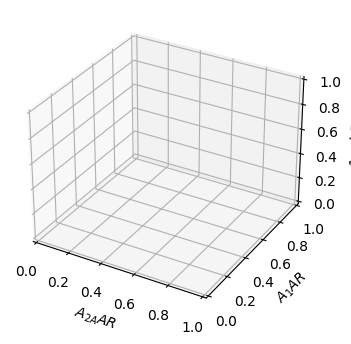

In [61]:
from matplotlib import cm
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("$A_{2A}AR$")
ax.set_ylabel("$A_{1}AR$")
ax.set_zlabel("$1-hERG$")

pareto_front = is_pareto_efficient(-df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float), return_mask=False)
aaa = df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float)
pf = aaa[pareto_front]

dfa = pd.DataFrame({'x': pf[:,0], 'y': pf[:,1], 'z': pf[:,2]})

Text(0.5, 0, '$1-hERG$')

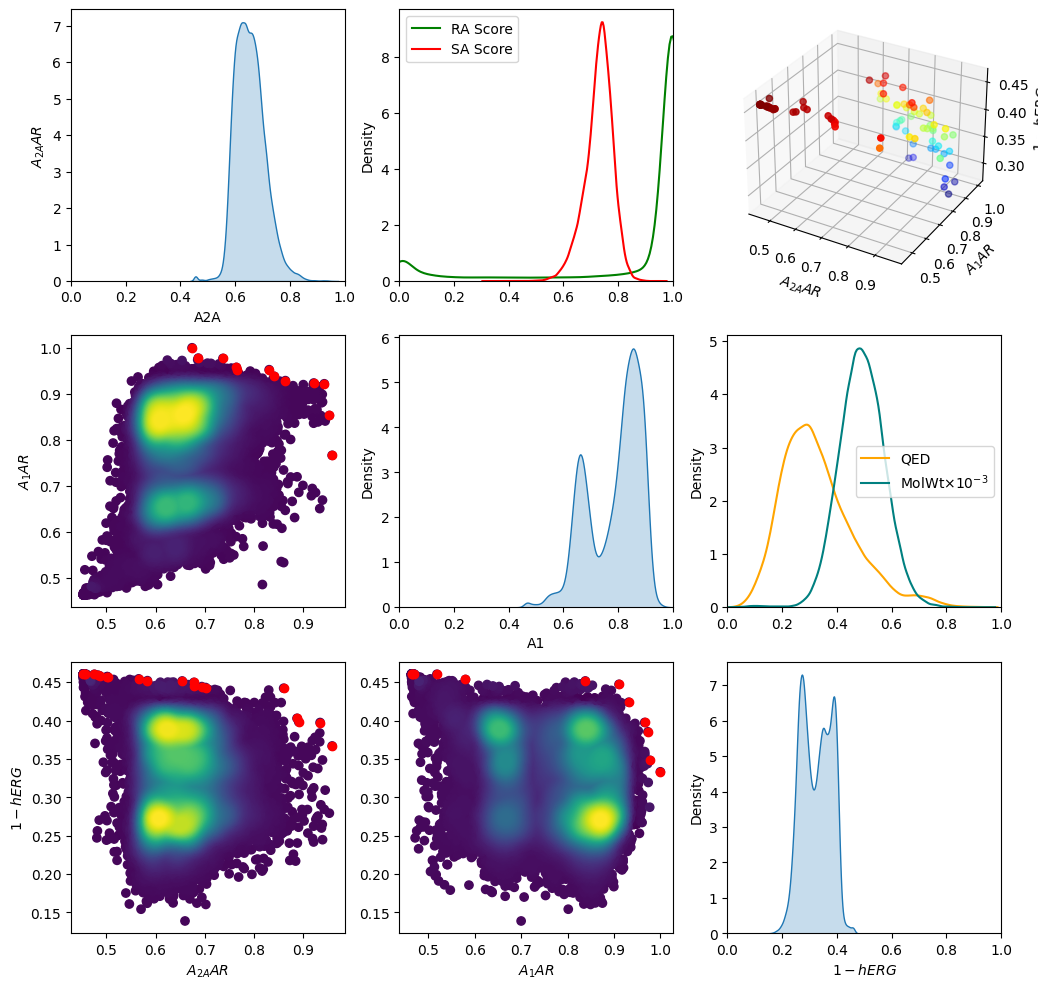

In [62]:
plt.close()
pf_col = "red"
fig, ax = plt.subplots(3, 3, figsize=(12,12))
# ax[2, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel("$A_{2A}AR$")
ax[1, 0].set_ylabel("$A_{1}AR$")
ax[2, 0].set_ylabel("$1-hERG$")
ax[2, 0].set_xlabel("$A_{2A}AR$")
ax[2, 1].set_xlabel("$A_{1}AR$")
ax[2, 2].set_xlabel("$1-hERG$")
# ax[2, 1].set_ylim([0, 1])
ax[2, 2].set_xlim([0, 1])
ax[1, 1].set_xlim([0, 1])
ax[0, 0].set_xlim([0, 1])
density_scatter(df["A2A"], df["hERG"], ax=ax[2, 0])
sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[0, 1], color="green")
sns.kdeplot(sa_scores, ax=ax[0, 1], color="red")
ax[0, 1].set_xlim([0, 1])
ax[0, 1].legend(labels=["RA Score", "SA Score"])
sns.kdeplot(qeds, ax=ax[1, 2], color="orange")
sns.kdeplot(sc_mws, ax=ax[1, 2], color="teal")
ax[1, 2].set_xlim([0, 1])
ax[1, 2].legend(labels=["QED", "MolWt$\\times10^{-3}$"])
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[1, 1], color="green")
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[2, 2], color="green")
ax[2, 0].scatter(a2a_herg_pf[:, 0], a2a_herg_pf[:, 1], color=pf_col)
density_scatter(df["A2A"], df["A1"], ax=ax[1, 0])
ax[1, 0].scatter(a2a_a1_pf[:, 0], a2a_a1_pf[:, 1], color=pf_col)
density_scatter(df["A1"], df["hERG"], ax=ax[2, 1])
ax[2, 1].scatter(a1_herg_pf[:, 0], a1_herg_pf[:, 1], color=pf_col)
sns.kdeplot(df["A2A"], ax=ax[0, 0], fill=True)
sns.kdeplot(df["A1"], ax=ax[1, 1], fill=True)
sns.kdeplot((df["hERG"]), ax=ax[2, 2], fill=True)
# ax[0, 1].axis('off')
# ax[0, 2].axis('off')
ax[0, 2].remove()
ax[0, 2]=fig.add_subplot(3,3,3,projection='3d')
ax[0, 2].scatter3D(dfa.x, dfa.y, dfa.z, c=dfa.z, cmap=cm.jet)
ax[0, 2].set_xlabel("$A_{2A}AR$")
ax[0, 2].set_ylabel("$A_{1}AR$")
ax[0, 2].set_zlabel("$1-hERG$")
# ax[1, 2].axis('off')

In [1]:
import torch

In [2]:
import pandas as pd

In [ ]:
gfn_base_pf = torch.load("../logs/mogfn/drugex_v2_tb_beta_96_lr_5e-4/pareto.pt")

In [ ]:
gfn_base_pf_smi = gfn_base_pf["pareto_front_smi"]

In [ ]:
pd.Series(gfn_base_pf_smi).to_csv("/home/julius/thesis/paper/gfnbasepfsmi_baseline.txt", header=None, index=False)

In [4]:
drugex_res = pd.read_hdf("/home/julius/thesis/paper/drugex_rascore_pf_results.hdf5", key="table")

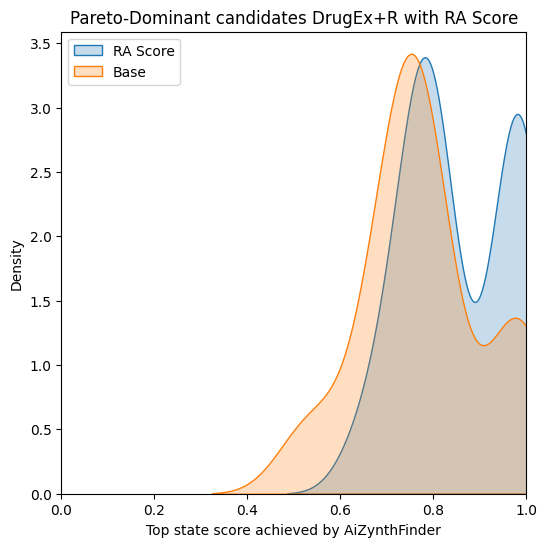

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Pareto-Dominant candidates DrugEx+R with RA Score")
sns.kdeplot(drugex_res["top_score"], ax=ax, fill=True)
ax.set_xlim([0, 1])
ax.set_xlabel("Top state score achieved by AiZynthFinder")
sns.kdeplot(drugex_base_res["top_score"], ax=ax, fill=True)
ax.set_xlabel("Top state score achieved by AiZynthFinder")
ax.legend(labels=["RA Score", "Base"], loc="upper left")


In [9]:
gfn_res = pd.read_hdf("/home/julius/thesis/paper/gfn_rascore_pf_results.hdf5", key="table")

In [63]:
drugex_base_res = pd.read_hdf("/home/julius/thesis/paper/output.hdf5", key="table")

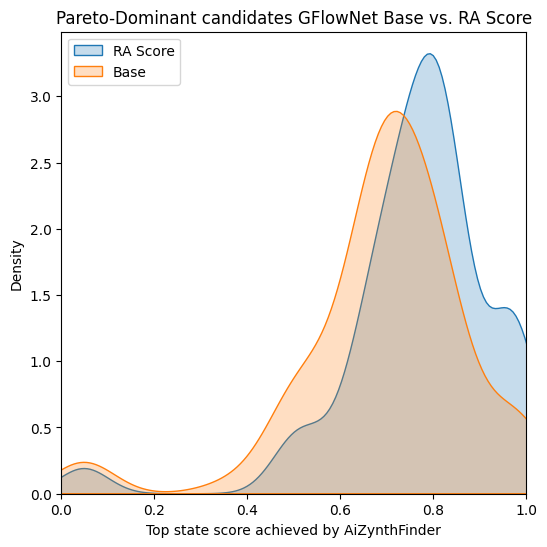

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(gfn_res["top_score"], ax=ax, fill=True)
ax.set_xlim([0, 1])
ax.set_xlabel("Top state score achieved by AiZynthFinder")
ax.set_title("Pareto-Dominant candidates GFlowNet Base vs. RA Score")
sns.kdeplot(gfn_base_res["top_score"], ax=ax, fill=True)
ax.set_xlabel("Top state score achieved by AiZynthFinder")
ax.legend(labels=["RA Score", "Base"], loc="upper left")


Text(0, 0.5, '# of Solved Routes')

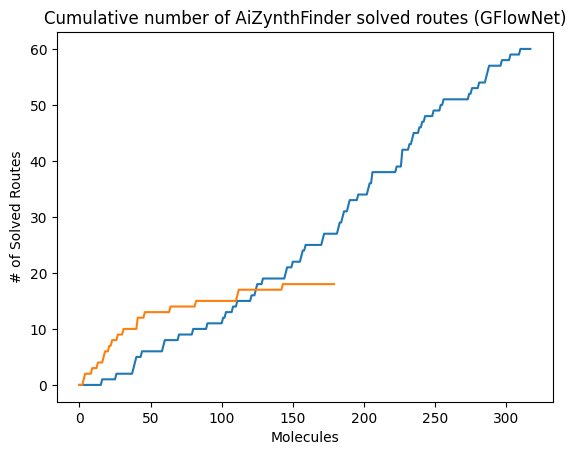

In [43]:
import numpy as np
plt.title("Cumulative number of AiZynthFinder solved routes (GFlowNet)")
plt.plot(np.cumsum(gfn_res["number_of_solved_routes"]))
plt.plot(np.cumsum(gfn_base_res["number_of_solved_routes"]))
plt.xlabel("Molecules")
plt.ylabel("# of Solved Routes")

In [68]:
gfn_res

,target,search_time,first_solution_time,first_solution_iteration,number_of_nodes,max_transforms,max_children,number_of_routes,number_of_solved_routes,top_score,...,number_of_steps,number_of_precursors,number_of_precursors_in_stock,precursors_in_stock,precursors_not_in_stock,precursors_availability,policy_used_counts,profiling,top_scores,trees
0,CC(O)NC(=O)CS,20.469669,0.0,0,280,7,14,46,0,0.725947,...,5,4,3,"O=C(O)CS, O=C(c1ccccc1)c1ccccc1, Brc1ccccc1",CC(N)O,Not in stock;zinc;zinc;zinc,{'uspto': 279},"{'expansion_calls': 234, 'reactants_generation...","0.7259, 0.7259, 0.7259, 0.7259, 0.7185, 0.7185...","[{'type': 'mol', 'hide': False, 'smiles': 'CC(..."
1,CC(C)=CNC(=O)[PH](=O)O,0.396831,0.0,0,1,0,0,1,0,0.049101,...,0,1,0,,CC(C)=CNC(=O)[PH](=O)O,Not in stock,{},"{'expansion_calls': 1, 'reactants_generations'...",0.0491,"[{'type': 'mol', 'hide': False, 'smiles': 'CC(..."
2,CC(=O)Nn1cnc2c(Br)ncnc21,20.167907,0.0,0,348,7,11,61,0,0.765960,...,6,5,4,"O=C(O)C(F)(F)F, O=C1CCC(=O)N1Br, CC(C)(C)OC(=O...",Nc1nc2c(ncn2N)c(=O)[nH]1,zinc;zinc;zinc;Not in stock;zinc,{'uspto': 347},"{'expansion_calls': 287, 'reactants_generation...","0.7660, 0.7660, 0.7624, 0.7624, 0.7624","[{'type': 'mol', 'hide': False, 'smiles': 'CC(..."
3,O=CI,0.369730,0.0,0,1,0,0,1,0,0.049101,...,0,1,0,,O=CI,Not in stock,{},"{'expansion_calls': 1, 'reactants_generations'...",0.0491,"[{'type': 'mol', 'hide': False, 'smiles': 'O=C..."
4,C[SH+]P(=O)(O)O,20.227084,0.0,0,148,7,6,33,0,0.500000,...,4,2,1,O=S(Cl)Cl,CCOP(=O)(OCCO)[SH+]C,Not in stock;zinc,{'uspto': 147},"{'expansion_calls': 121, 'reactants_generation...","0.5000, 0.4884, 0.4810, 0.4810, 0.4774","[{'type': 'mol', 'hide': False, 'smiles': 'C[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,COc1cnc(-c2cccc(-c3cccnc3)c2-c2nc(-c3cccc(-c4c...,20.265000,0.0,0,244,7,29,48,0,0.816667,...,4,6,5,"COc1cnc(Cl)nc1, CC(C)(O)C(C)(C)O, CC(C)(O)C(C)...",Brc1cccc(I)c1-c1nc(-c2cccc(-c3cccnc3)c2-c2ccnc...,zinc;zinc;zinc;zinc;Not in stock;zinc,{'uspto': 243},"{'expansion_calls': 196, 'reactants_generation...","0.8167, 0.8167, 0.8051, 0.8051, 0.7976, 0.7976","[{'type': 'mol', 'hide': False, 'smiles': 'COc..."
314,NC(=O)c1nc(-n2nc(-n3cc(-n4cccn4)cn3)c(-c3ncccn...,20.116235,0.0,0,200,7,16,55,0,0.765960,...,6,10,8,"CCOC(=O)c1nc(Br)cs1, Brc1ncccn1, Clc1cc(Br)[nH...","N, O=C([O-])c1cnn(CO)c1",zinc;Not in stock;zinc;zinc;zinc;zinc;zinc;zin...,{'uspto': 199},"{'expansion_calls': 145, 'reactants_generation...","0.7660, 0.7660, 0.7660, 0.7660, 0.7448","[{'type': 'mol', 'hide': False, 'smiles': 'NC(..."
315,NC(=O)C(=O)Nc1cc(-c2ncccn2)nc(-n2cccn2)c1-c1nccs1,20.383406,0.0,0,244,7,14,36,0,0.837210,...,6,8,7,"c1cn[nH]c1, Brc1nccs1, CC(C)(O)C(C)(C)O, CC(C)...",NC(=O)C(=O)Nc1cc(Br)nc(-c2ncccn2)c1,zinc;zinc;zinc;zinc;zinc;zinc;zinc;Not in stock,{'uspto': 243},"{'expansion_calls': 208, 'reactants_generation...","0.8372, 0.8277, 0.8202, 0.8202, 0.8202, 0.8202","[{'type': 'mol', 'hide': False, 'smiles': 'NC(..."
316,NC(=O)c1cnc(-c2nc(-c3nc(-c4c(C(=O)[O-])ccnc4-c...,20.812188,0.0,0,220,7,22,44,0,0.714871,...,7,4,3,"CC(C)(C)N, OB(O)c1ccccc1, O=C1CCC(=O)N1Cl",CCOC(=O)c1cnc(-c2nc(-c3nc(-c4cnccc4C(=O)[O-])c...,zinc;zinc;Not in stock;zinc,{'uspto': 219},"{'expansion_calls': 176, 'reactants_generation...","0.7149, 0.7149, 0.6583, 0.6583, 0.6583, 0.6583","[{'type': 'mol', 'hide': False, 'smiles': 'NC(..."
